# Setup

In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2


In [2]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"

In [3]:
restore_model=False
train_model=True

In [4]:
import sys 
root = "/lhome/ific/a/aamerio/github/cfm-jax"
sys.path.append(f"{root}/examples/sbi-benchmarks")
sys.path.append(f"{root}/src")

In [5]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = f"{root}/examples/sbi-benchmarks/two_moons"
checkpoint_dir = f"{notebook_path}/checkpoints/two_moons_jflux"

os.makedirs(checkpoint_dir, exist_ok=True)

In [6]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx
import optax
from optax.contrib import reduce_on_plateau

from numpyro import distributions as dist

from corner import corner

import numpy as np

from tqdm.auto import tqdm

from functools import partial


/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
PATIENCE = 10  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100
# max LR
MAX_LR = 1e-3  # @param{type:"number"}
# Min scale for the learning rate:
MIN_LR = 0  # @param{type:"number"}
MIN_SCALE = MIN_LR / MAX_LR  # @param{type:"number"}

In [8]:
from sbi_utils.sbi_tasks import TwoMoons
from sbi_utils.dataloader import InfiniteDataLoader

from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver

define the task

In [9]:
twomoons = TwoMoons()
task = twomoons.task
prior = twomoons.get_prior()
simulator = twomoons.get_simulator()

In [10]:
@partial(jax.jit, static_argnames=["size"])
def sample_prior(size):
    return jnp.array(prior.sample((size,)))

In [11]:
reference_samples = task.get_reference_posterior_samples(num_observation=8)

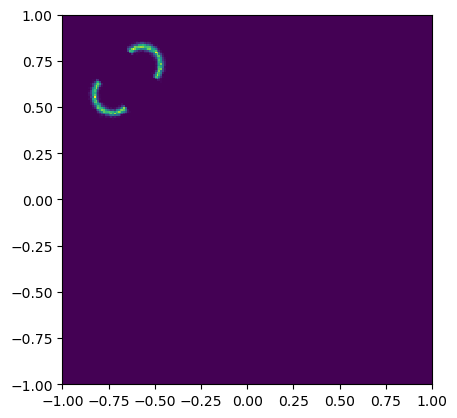

In [12]:
plt.hist2d(reference_samples[:, 0], reference_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# dataset

In [13]:
# make a dataset
nsamples = int(1e5)
val_size = 512
theta = prior.sample((nsamples+val_size,))
xs = jnp.array(simulator(theta))
node_ids = jnp.array(twomoons.get_node_id())
dim_theta = twomoons.get_theta_dim()
dim_x = twomoons.get_x_dim()

# turn them into jax arrays
theta = jnp.array(theta)
xs = jnp.array(xs)

# concatenate the data, theta and xs
data = jnp.concatenate((theta, xs), axis=-1)


train_data = data[:nsamples]
val_data = data[nsamples:]


In [14]:
cond_ids = jnp.arange(dim_theta, dtype=jnp.int32).reshape(1,-1,1)
obs_ids = jnp.arange(dim_x, dtype=jnp.int32).reshape(1,-1,1)

In [15]:
batch_size = 4*1024 # the model greatly benefits from larger batch sizes to avoid overfitting, but this is limited by the GPU memory
dataset = InfiniteDataLoader(train_data, batch_size, rng=nnx.Rngs(0).dataset())

# define the CFM model

In [16]:
from models import FluxParams, Flux, FluxCFMLoss

In [17]:
path = AffineProbPath(scheduler=CondOTScheduler()) # define the probability path

In [18]:
params=FluxParams(
            in_channels=1,
            vec_in_dim=None,
            context_in_dim=1,
            mlp_ratio=3,
            qkv_multiplier=1,
            num_heads=4,
            depth=4,
            depth_single_blocks=8,
            axes_dim=[10,],
            use_rope = False,
            obs_dim = 2,
            cond_dim = 2,
            qkv_bias=True,
            guidance_embed=False,
            rngs=nnx.Rngs(default=42),
            param_dtype=jnp.bfloat16,
        )

In [19]:
loss_fn_cfm = FluxCFMLoss(path, cfg_scale=0.9)

In [20]:
p0_dist_model = dist.Independent(
    dist.Normal(loc=jnp.zeros((2,)), scale=jnp.ones((2,))),
    reinterpreted_batch_ndims=1
)

In [21]:
def loss_fn_(vf_model, batch, key: jax.random.PRNGKey):

    obs = batch[:,:2][...,None]
    cond = batch[:,2:][...,None]

    key1, key2 = jax.random.split(key, 2)

    x_1 = obs
    x_0 = jax.random.normal(key1, x_1.shape)
    t = jax.random.uniform(key2, x_1.shape[0])
    
    batch = (x_0, x_1, t)

    loss=loss_fn_cfm(vf_model, batch, cond, obs_ids, cond_ids)
    return loss

In [22]:
@nnx.jit
def train_loss(vf_model, key: jax.random.PRNGKey):
    batch = next(dataset) # n, T_max, 1
    return loss_fn_(vf_model, batch, key)

In [23]:
@nnx.jit
def val_loss(vf_model, key):
    batch = val_data
    return loss_fn_(vf_model, batch, key)

In [24]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: train_loss(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads, value=loss)  # In place updates.
    return loss

In [25]:
vf_model = Flux(params)

In [26]:
# restore the model
if restore_model:
    model_state = nnx.state(vf_model)
    graphdef, abstract_state = nnx.split(vf_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            1,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )

    vf_model= nnx.merge(graphdef, restored["state"])
    print("Restored model from checkpoint")

In [27]:
# # linear learning rate schedule
# nsteps = 10_000 
# nepochs = 5


# schedule = optax.schedules.linear_schedule(1e-3, 1e-6, 40000, 10000)

# opt = optax.chain(optax.adaptive_grad_clip(10.0), optax.adamw(schedule))

# # opt = optax.MultiSteps(opt, 2)

# optimizer = nnx.Optimizer(vf_model, opt)

In [28]:
# reduce on plateau schedule
nsteps = 10_000
nepochs = 5

multistep = 1 # if the GPU cannot support batch sizes of at least 4k, adjust this value accordingly to get the desired effective batch size

warmup_schedule = optax.schedules.warmup_constant_schedule(1e-5, MAX_LR, warmup_steps=1000)

opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    optax.adamw(warmup_schedule),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)
if multistep > 1:
    opt = optax.MultiSteps(opt, multistep)
optimizer = nnx.Optimizer(vf_model, opt)

In [29]:
rngs = nnx.Rngs(0)

In [30]:
best_state = nnx.state(vf_model)
best_val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100

loss_array = []
val_loss_array = []

early_stopping = True

In [ ]:
if train_model:
    vf_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        v_l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state
                graphdef, abstract_state = nnx.split(vf_model)

                vf_model = nnx.merge(graphdef, best_state)
                break

            loss = train_step(vf_model, optimizer, rngs.train_step())
            l += loss.item()
            
            v_loss = val_loss(vf_model, rngs.val_step())
            v_l += v_loss.item()

            if j > 0 and j % 100 == 0:
                loss_ = l / 100
                val_ = v_l / 100

                ratio1 = val_ / loss_
                ratio2 = val_ / best_val_loss_value

                # if ratio1 < val_error_ratio and ratio2 < 1.05:
                if ratio1 < val_error_ratio:
                    if val_ < best_val_loss_value:
                        best_val_loss_value = val_
                        best_state = nnx.state(vf_model)
                    counter = 0
                else:
                    counter += 1

                # scale = tree_get(optimizer.opt_state, "ReduceLROnPlateauState").scale.value
                # pbar.set_postfix(loss=f"{l/(100):.4f}", ratio=f"{ratio:.4f}", counter=counter, lr_scale=scale, val_loss = f"{val_:.4f}" )
                pbar.set_postfix(
                    loss=f"{loss_:.4f}",
                    ratio=f"{ratio1:.4f}",
                    counter=counter,
                    val_loss=f"{val_:.4f}",
                )
                loss_array.append(loss_)
                val_loss_array.append(val_)
                l = 0
                v_l = 0

            # if j>0 and j%3000 == 0:
            #     idx = 8
            #     vf_wrapped = FluxWrapper(vf_model)
            #     samples, true_param, reference_samples = get_samples(vf_wrapped, idx)
            #     plot_samples(samples, true_param)
        # print(l)

    vf_model.eval()

  0%|          | 1/10000 [00:46<128:20:52, 46.21s/it]

In [ ]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=2,
            keep_checkpoints_without_metrics=True,
            create=True,
        ),
    )
    model_state = nnx.state(vf_model)
    checkpoint_manager.save(
        1, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()

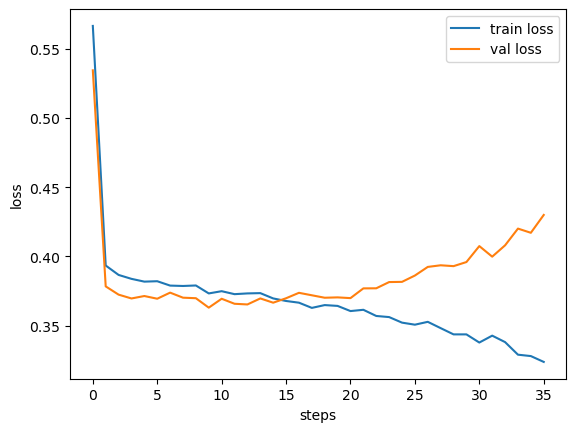

In [ ]:
if train_model:
    plt.plot(loss_array, label="train loss")
    plt.plot(val_loss_array, label="val loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

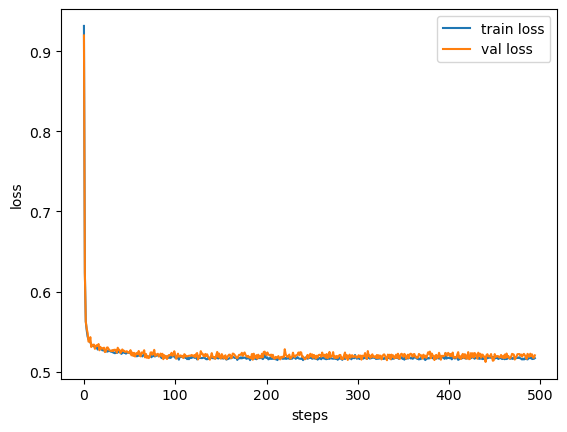

# sample the posterior

## utils

In [ ]:
from utils.model_wrapping import ModelWrapper, GuidedModelWrapper
from einops import rearrange

class FluxWrapper(ModelWrapper):
    def __init__(self, model):
        super().__init__(model)

    def __call__(self, x, t, args, **kwargs):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')

        return jnp.squeeze(self.model(obs=x, timesteps=t, conditioned=True, **kwargs), axis=-1)

class GuidedFluxWrapper(GuidedModelWrapper):
    def __init__(self, model, cfg_scale):
        super().__init__(model, cfg_scale)

    def __call__(self, x, t, args, **kwargs):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')

        return jnp.squeeze(self.model(obs=x, timesteps=t, conditioned=True, **kwargs), axis=-1)

In [ ]:
def get_samples(vf_wrapped, idx, nsamples=10_000):
    observation =  jnp.array(twomoons.get_observation(idx))
    true_param = jnp.array(task.get_true_parameters(idx))
    reference_samples = task.get_reference_posterior_samples(num_observation=idx)

    rng = jax.random.PRNGKey(45)

    step_size = 0.01

    rng, key1 = jax.random.split(rng, 2)

    x_init = jax.random.normal(key1,(nsamples, dim_theta)) # n, T_max, 1
    cond = jnp.broadcast_to(observation[...,None], (nsamples, dim_x, 1)) # n, dim_theta, 1

    solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
    model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

    sampler_ = solver.get_sampler(method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
    samples = sampler_(x_init)  # sample from the model

    return samples, true_param, reference_samples

def plot_samples(samples, true_param):
    plt.hist2d(samples[:,0], samples[:,1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
    # same ratio on axis 
    plt.scatter(true_param[0,0], true_param[0,1], s=100, color='red', alpha=0.5, marker='x')
    # plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.show()

## plotting

In [ ]:
idx = 8
vf_wrapped = FluxWrapper(vf_model)
samples, true_param, reference_samples = get_samples(vf_wrapped, idx, 100_000)

In [ ]:
posterior_samples = samples

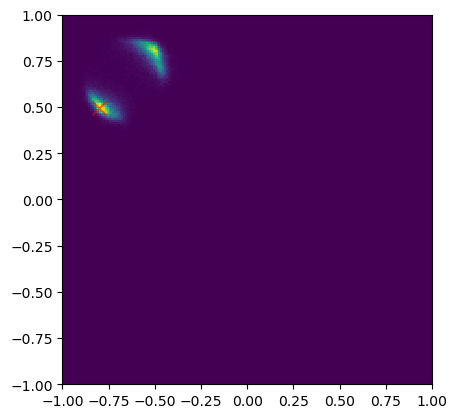

In [ ]:
plot_samples(posterior_samples, true_param)

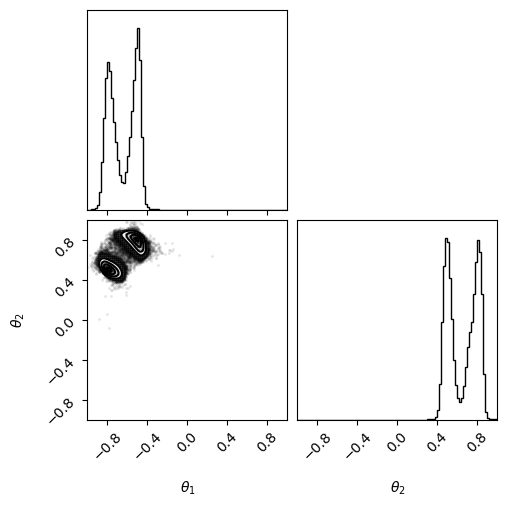

In [ ]:
corner(np.array(posterior_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

/tmp/ipykernel_72684/1071246627.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])


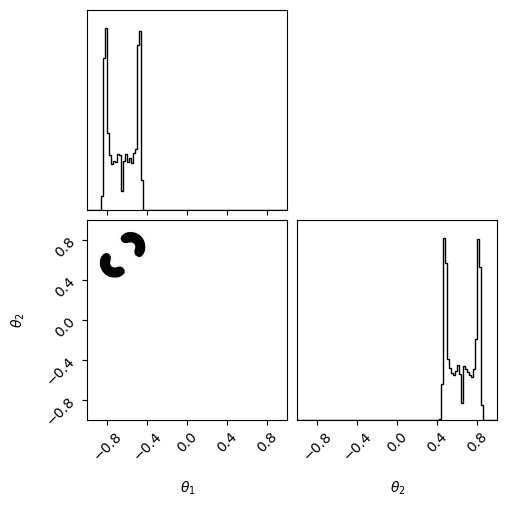

In [ ]:
corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# evaluate the posterior

In [ ]:
idx = 8
observation = jnp.array(twomoons.get_observation(idx))
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class

In [ ]:
p0_cond = dist.Independent(
    dist.Normal(loc=jnp.zeros((2,)), scale=jnp.ones((2,))),
    reinterpreted_batch_ndims=1
)

In [ ]:
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-1, 1, grid_size), jnp.linspace(-1, 1, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

# cond = jnp.broadcast_to(observation[...,None], (x_1.shape[0], dim_theta,1)) # n, dim_theta, 1
# cond = jnp.broadcast_to(observation, (x_1.shape[0], dim_theta)) # n, dim_theta, 1
cond = jnp.broadcast_to(observation, (1, dim_theta)) # n, dim_theta, 1

obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": posterior_faithfull}

In [ ]:
# get the logprob
# logp_sampler = solver.get_unnormalized_logprob(condition_mask=condition_mask, time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_dist_model.log_prob, model_extras=model_extras)
logp_sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_cond.log_prob, model_extras=model_extras)
# create an y_init which has theta on the first position and x1,x2 on the second and third position

# y_init = p0_cond.sample(jax.random.PRNGKey(0), (x_1.shape[0],))  # n, dim_theta
y_init = x_1

exact_log_p = logp_sampler(y_init)
p = jnp.exp(exact_log_p)[-1]


In [ ]:
p_grid = p.reshape((grid_size, grid_size))
plt.imshow(p_grid, origin='lower', aspect='auto', extent=(-1, 1, -1, 1), cmap='viridis')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.colorbar()
plt.show()

# sample with guidance

In [ ]:
gvf_wrapped = GuidedFluxWrapper(vf_model, cfg_scale=0.95)

In [ ]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
idx=8

In [ ]:
samples = get_samples(gvf_wrapped, idx, nsamples=100_000, edge_mask=None)[0]

In [ ]:
posterior_samples = samples

plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=100, range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim((-1,1))
# plt.ylim((-1,1))
plt.show()

In [ ]:
corner(np.array(posterior_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# C2ST test

In [ ]:
from sbibm.metrics import c2st

In [ ]:
# convert posterior samples to a torch array
import torch
idx = 2
reference_samples = task.get_reference_posterior_samples(num_observation=idx)
posterior_samples = get_samples(vf_wrapped, idx, nsamples=reference_samples.shape[0])[0]
posterior_samples_torch = torch.tensor(np.array(posterior_samples), dtype=torch.float32)

posterior_samples_cfg = get_samples(gvf_wrapped, idx, nsamples=reference_samples.shape[0], edge_mask=None)[0]
posterior_samples_cfg_torch = torch.tensor(np.array(posterior_samples_cfg), dtype=torch.float32)

In [ ]:
c2st_accuracy = c2st(reference_samples, posterior_samples_torch)
c2st_accuracy_cfg = c2st(reference_samples, posterior_samples_cfg_torch)

In [ ]:
c2st_accuracy, c2st_accuracy_cfg